# Binary Image Classifier for Smaller Dataset

**In this project we experiments the performances of 3 different models on a smaller imaged-based dataset.**

**The data set has two classes, each of which has about 300 iamges.**

## 1. Project Setup

In [112]:
!pip install tensorflow opencv-python matplotlib
!pip list

Package                      Version     Editable project location
---------------------------- ----------- ------------------------------------
absl-py                      1.3.0
alembic                      1.12.0
anyio                        3.5.0
appnope                      0.1.2
archspec                     0.2.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
astunparse                   1.6.3
async-generator              1.10
async-lru                    2.0.4
attrs                        23.1.0
autograd                     1.3
Babel                        2.10.3
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       4.1.0
boltons                      23.0.0
Box2D                        2.3.10      /Users/jiamingli/pybox2d_dev/library
box2d-py                     2.3.8
Brotli                       1.0.9
cachetools                   5.2.0
certifi                      2023.11.17
certipy                      0.1.

In [113]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[]

## 2. Validate Images


In [114]:
data_dir = 'data/d'
image_exts = ['jpeg','jpg', 'bmp', 'png']

if '.DS_Store' in os.listdir(data_dir):
    path = os.path.join(data_dir, '.DS_Store')
    os.remove(path)

classes = []
for image_class in os.listdir(data_dir):
    classes.append(image_class)
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
print("Classes: ",classes)

Image not in ext list data/d/not guilty/.DS_Store
Image not in ext list data/d/guilty/.DS_Store
Classes:  ['not guilty', 'guilty']


## 3. Load & Scale Data

In [115]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,class_names=classes,image_size=(256, 256),)

Found 600 files belonging to 2 classes.


In [116]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch_size = len(batch[0])
batch[0].shape

(32, 256, 256, 3)

One batch of data contains 32 images and each of which is stored in an 3d array of size (256,256,3), the 3 here represents the RBG colors.

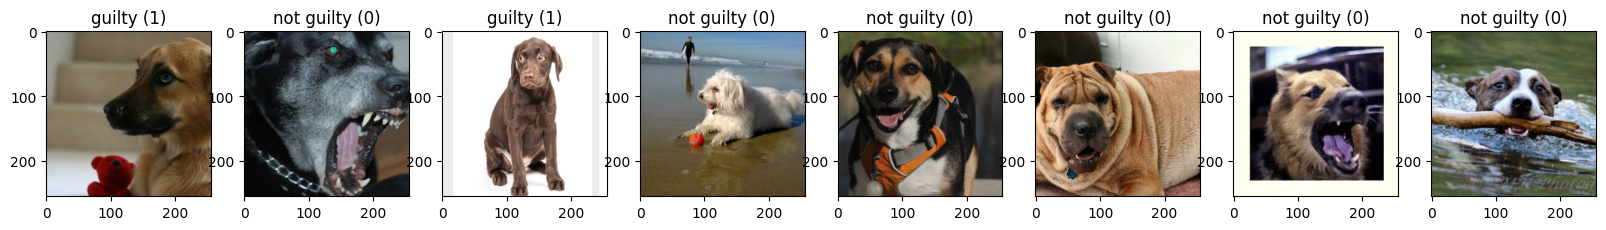

In [117]:
fig, ax = plt.subplots(ncols=8,figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    title = str(classes[batch[1][idx]]) + " (" + str(batch[1][idx]) + ")"
    ax[idx].title.set_text(title)

In [118]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.59411764, 0.6215686 , 0.4490196 ],
          [0.6022059 , 0.62965685, 0.4615196 ],
          [0.6098039 , 0.63529414, 0.47230393],
          ...,
          [0.24093138, 0.27622548, 0.16887255],
          [0.22598039, 0.2615196 , 0.1392157 ],
          [0.22892156, 0.26740196, 0.13627452]],
 
         [[0.6       , 0.63039213, 0.4490196 ],
          [0.60588235, 0.6362745 , 0.45490196],
          [0.6127451 , 0.6382353 , 0.47009805],
          ...,
          [0.21593137, 0.2512255 , 0.13946079],
          [0.19068627, 0.22696078, 0.10245098],
          [0.20465687, 0.24387255, 0.11053921]],
 
         [[0.60490197, 0.6362745 , 0.4480392 ],
          [0.6107843 , 0.64215684, 0.45392156],
          [0.61764705, 0.64705884, 0.46372548],
          ...,
          [0.2389706 , 0.2742647 , 0.16053921],
          [0.18553922, 0.22181372, 0.09730392],
          [0.21053922, 0.2497549 , 0.11568628]],
 
         ...,
 
         [[0.6431373 , 0.65710783, 0.42916667],
          [0.64313

All RBG colors has been converted from 0-255 to 0-1

## 4. Split Data

In [119]:
# Train - Validation - Test - 70% - 20% - 10%
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [120]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 5. SVM

In [121]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV


In [122]:
X_train = np.concatenate([x for x, y in train], axis=0)
X_train_flat = X_train.reshape(len(X_train),-1)
y_train = np.concatenate([y for x, y in train], axis=0)

X_val = np.concatenate([x for x, y in val], axis=0)
X_val_flat = X_val.reshape(len(X_val),-1)
y_val = np.concatenate([y for x, y in val], axis=0)

X_test = np.concatenate([x for x, y in test], axis=0)
X_test_flat = X_test.reshape(len(X_test),-1)
y_test = np.concatenate([y for x, y in test], axis=0)

In [123]:
from sklearn.model_selection import ParameterGrid
# Define the grid with different kernels and associated hyperparameters
grid = [{'kernel': ['linear'], 'C':[0.1, 1, 10]},
        {'kernel': ['rbf'], 'gamma': [0.1, 0.01, 0.001]},
        {'kernel': ['poly'], 'degree': [2, 3, 4, 5]}]

# Generate parameter combinations
parameter_combinations = list(ParameterGrid(grid))

# Perform grid search to find the best hyperparameters
best_accuracy = 0.0
best_model = None
best_params = None
accuracies = []
for params in parameter_combinations:
    svm_model = SVC(**params)
    svm_model.fit(X_train_flat, y_train)
    
    # Predict on the validation set
    y_valid_pred = svm_model.predict(X_val_flat)
    
    # Evaluate the model on the validation set
    accuracy_valid = accuracy_score(y_val, y_valid_pred)
    accuracies.append((params, accuracy_valid))

    # Update best model if accuracy improves
    if accuracy_valid > best_accuracy:
        best_accuracy = accuracy_valid
        best_model = svm_model
        best_params = params

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'gamma': 0.1, 'kernel': 'rbf'}


In [124]:
# Validation accuracies
accuracies

[({'C': 0.1, 'kernel': 'linear'}, 0.5416666666666666),
 ({'C': 1, 'kernel': 'linear'}, 0.5416666666666666),
 ({'C': 10, 'kernel': 'linear'}, 0.5416666666666666),
 ({'gamma': 0.1, 'kernel': 'rbf'}, 0.5520833333333334),
 ({'gamma': 0.01, 'kernel': 'rbf'}, 0.5520833333333334),
 ({'gamma': 0.001, 'kernel': 'rbf'}, 0.5520833333333334),
 ({'degree': 2, 'kernel': 'poly'}, 0.5520833333333334),
 ({'degree': 3, 'kernel': 'poly'}, 0.5520833333333334),
 ({'degree': 4, 'kernel': 'poly'}, 0.5520833333333334),
 ({'degree': 5, 'kernel': 'poly'}, 0.5416666666666666)]

In [125]:
# Predict on the test set using the best model
y_test_pred = best_model.predict(X_test_flat)
# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)

print('Accuracy:\t', accuracy_test)
print('Recall:\t\t', recall_test)
print('Precision:\t', precision_test)

Accuracy:	 0.53125
Recall:		 0.42105263157894735
Precision:	 0.6666666666666666


## 8. CNN

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

### 8.1 Base CNN (Model A)

In [127]:
modelA = Sequential()
modelA.add(Conv2D(16, (5,5), 1, activation='relu', input_shape=(256,256,3)))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Conv2D(16, (3,3), 1, activation='relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Conv2D(32, (3,3), 1, activation='relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Conv2D(32, (3,3), 1, activation='relu'))
modelA.add(MaxPooling2D(pool_size=(2, 2)))
modelA.add(Flatten())
modelA.add(Dense(256, activation='relu'))
modelA.add(Dense(1, activation='sigmoid'))

### 8.2 Model B

In [128]:
modelB = Sequential()
modelB.add(Conv2D(32, (5,5), 1, activation='relu', input_shape=(256,256,3)))
modelB.add(MaxPooling2D(pool_size=(2, 2)))
modelB.add(Conv2D(32, (3,3), 1, activation='relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))
modelB.add(Conv2D(64, (3,3), 1, activation='relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))
modelB.add(Conv2D(64, (3,3), 1, activation='relu'))
modelB.add(MaxPooling2D(pool_size=(2, 2)))
modelB.add(Flatten())
modelB.add(Dense(256, activation='relu'))
modelB.add(Dense(1, activation='sigmoid'))

### 8.3 Model C

In [143]:
modelC = Sequential()
modelC.add(Conv2D(16, (5,5), 1, activation='relu', input_shape=(256,256,3)))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Conv2D(16, (3,3), 1, activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Dropout(0.3))
modelC.add(Conv2D(32, (3,3), 1, activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Conv2D(32, (3,3), 1, activation='relu'))
modelC.add(MaxPooling2D(pool_size=(2, 2)))
modelC.add(Flatten())
modelC.add(Dense(256, activation='relu'))
modelC.add(Dropout(0.3))
modelC.add(Dense(1, activation='sigmoid'))

### 8.4 Model D

In [130]:
modelD = Sequential()
modelD.add(Conv2D(16, (5,5), 1, activation='relu', input_shape=(256,256,3)))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Conv2D(16, (3,3), 1, activation='relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Conv2D(32, (3,3), 1, activation='relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Conv2D(32, (3,3), 1, activation='relu'))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(MaxPooling2D(pool_size=(2, 2)))
modelD.add(Flatten())
modelD.add(Dense(256, activation='relu'))
modelD.add(Dense(1, activation='sigmoid'))

In [144]:
# Choose which model to test on
model = modelC
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 126, 126, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 124, 124, 16)      2320      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 62, 62, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 62, 62, 16)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 60, 60, 32)      

In [146]:
logdir='cnn_logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


13/13 [==============================] - 8s 530ms/step - loss: 0.7070 - accuracy: 0.5048 - val_loss: 0.6934 - val_accuracy: 0.5104
Epoch 2/15
13/13 [==============================] - 6s 458ms/step - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6930 - val_accuracy: 0.4896
Epoch 3/15
13/13 [==============================] - 7s 502ms/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6908 - val_accuracy: 0.4688
Epoch 4/15
13/13 [==============================] - 6s 470ms/step - loss: 0.6873 - accuracy: 0.5312 - val_loss: 0.6794 - val_accuracy: 0.5312
Epoch 5/15
13/13 [==============================] - 7s 485ms/step - loss: 0.6672 - accuracy: 0.5577 - val_loss: 0.6515 - val_accuracy: 0.6250
Epoch 6/15
13/13 [==============================] - 7s 489ms/step - loss: 0.6566 - accuracy: 0.6082 - val_loss: 0.6542 - val_accuracy: 0.5833
Epoch 7/15
13/13 [==============================] - 7s 483ms/step - loss: 0.6507 - accuracy: 0.6346 - val_loss: 0.6245 - val_accuracy: 0.6146
Epoch 8/15
13/13 

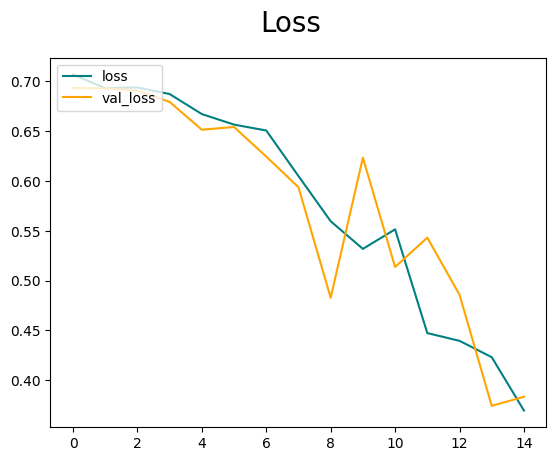

In [147]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

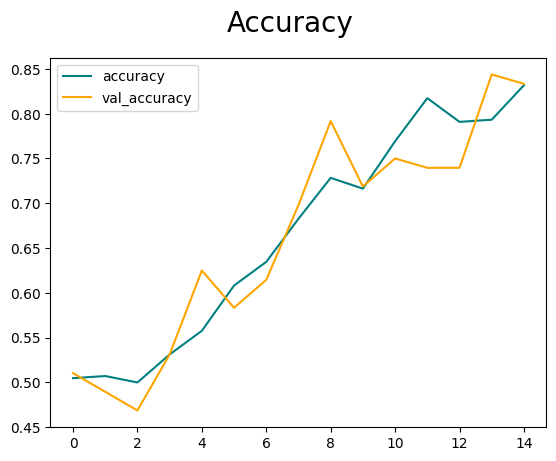

In [148]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [149]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [150]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [151]:
y_test = []
y_hat = []
for batch in test.as_numpy_iterator(): 
    X, y = batch
    y_test.append(y)
    yhat = model.predict(X)
    yhat = [0 if x<0.5 else 1 for x in yhat.reshape(-1,1)]
    y_hat.append(yhat)
    
y_test = [x  for sublist in y_test for x in sublist]
y_hat = [x  for sublist in y_hat for x in sublist]

print(y_test)
print(y_hat)
pre.update_state(y_test, y_hat)
re.update_state(y_test, y_hat)
acc.update_state(y_test, y_hat)

1/1 [==============================] - 0s 140ms/step
[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]


<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=32.0>

In [152]:
print("Precision:\t",float(pre.result()),
"\nRecall:\t\t",float(re.result()), 
"\nAccuracy:\t",float(acc.result()))

Precision:	 0.8823529481887817 
Recall:		 0.9375 
Accuracy:	 0.90625


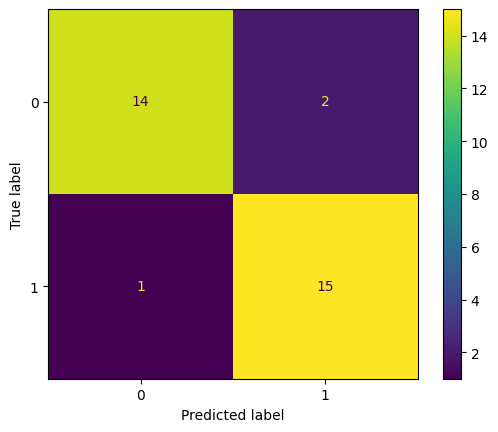

In [153]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

## 7. CNN-SVM

In [161]:
from keras.models import Model
X_train = np.concatenate([x for x, y in train], axis=0)
X_val = np.concatenate([x for x, y in val], axis=0)
X_test = np.concatenate([x for x, y in test], axis=0)

# get_layer(x)
# x = the dense layer after Flattern()
# see model.summary() for the name of the dense layer
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_24').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

best_model.fit(feat_train,y_train)

best_model.score(feat_val,y_val)
# Predict on the test set using the best model
y_test_pred = best_model.predict(feat_test)
# Evaluate the best model on the test set
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)

print('Accuracy:\t', accuracy_test)
print('Recall:\t\t', recall_test)
print('Precision:\t', precision_test)

13/13 [==============================] - 2s 111ms/step
(416, 256)
3/3 [==============================] - 0s 138ms/step
(96, 256)
1/1 [==============================] - 0s 110ms/step
(32, 256)
Accuracy:	 0.625
Recall:		 0.42857142857142855
Precision:	 0.6


In [ ]:
# Save model
# from tensorflow.keras.models import load_model
# model.save(os.path.join('models','imageclassifier.h5'))